In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_csv("Data - data (2).csv.csv")

#Removo linhas com valores nulos e duplicatas
df = df.dropna()
df = df.drop_duplicates()

#Formato as colunas para terem um formato mais apropriado
df['InvoiceNo'] = df['InvoiceNo'].astype("str")
df['StockCode'] = df['StockCode'].astype("str")
df['Description'] = df['Description'].astype("str")
df["Quantity"] = df["Quantity"].astype("Int64")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["UnitPrice"] = df["UnitPrice"].astype("float64")
df["CustomerID"] = df["CustomerID"].astype("Int64")
df["Country"] = df["Country"].astype("str")

#Manter apenas linhas com valores acima de 0
dfRemoveZeroPrice = df.copy().query("UnitPrice > 0")
dfRemoveZeroQuantity = dfRemoveZeroPrice.copy().query("Quantity >= 1")

#Remoção dos "outliers"
dfRemoveOutliers = dfRemoveZeroQuantity.copy().query("Quantity > 10.000 or UnitPrice > 5.000")

#Crio a coluna de valor total de venda
dfTotalSellValue = dfRemoveOutliers.copy()
dfTotalSellValue["TotalSellValue"] = dfTotalSellValue["UnitPrice"] * dfTotalSellValue["Quantity"]

#Crio a coluna de ultima venda total
dfLastSellValue = dfTotalSellValue.copy()
dfLastSellValue['LastSaleDate'] = dfTotalSellValue['InvoiceDate'].max()

#Crio uma tabela final para as analises
dfSalesTable = dfLastSellValue.copy()

dfSalesTable.describe()

<ipython-input-379-376f13663de0>:22: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  dfRemoveZeroQuantity = dfRemoveZeroPrice.copy().query("Quantity >= 1")
<ipython-input-379-376f13663de0>:25: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  dfRemoveOutliers = dfRemoveZeroQuantity.copy().query("Quantity > 10.000 or UnitPrice > 5.000")


,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalSellValue,LastSaleDate
count,173880.0,173880,173880.000000,173880.0,173880.0,173880
mean,24.655256,2011-07-06 06:00:42.107315712,4.180201,15054.15448,40.074686,2011-12-09 12:50:00
min,1.0,2010-12-01 08:26:00,0.040000,12346.0,0.78,2011-12-09 12:50:00
25%,5.0,2011-04-04 13:57:00,0.850000,13571.0,10.5,2011-12-09 12:50:00
50%,12.0,2011-07-22 16:03:00,1.650000,14911.0,17.4,2011-12-09 12:50:00
75%,24.0,2011-10-13 10:32:30,5.950000,16558.0,33.0,2011-12-09 12:50:00
max,80995.0,2011-12-09 12:50:00,8142.750000,18287.0,168469.6,2011-12-09 12:50:00
std,270.78596,NaN,33.363501,1724.345629,466.859881,NaN


In [ ]:
#Visualização da tabela
dfSalesTable.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSellValue,LastSaleDate
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.3,2011-12-09 12:50:00
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08,2011-12-09 12:50:00
16,536367,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2010-12-01 08:34:00,9.95,13047,United Kingdom,19.9,2011-12-09 12:50:00
17,536367,21754,HOME BUILDING BLOCK WORD,3,2010-12-01 08:34:00,5.95,13047,United Kingdom,17.85,2011-12-09 12:50:00
18,536367,21755,LOVE BUILDING BLOCK WORD,3,2010-12-01 08:34:00,5.95,13047,United Kingdom,17.85,2011-12-09 12:50:00


In [ ]:
#Monto a base para as visões RFM de cada cliente
dfR = dfSalesTable.groupby('CustomerID')['InvoiceDate'].max()
dfF = dfSalesTable.groupby('CustomerID')['InvoiceNo'].nunique()
dfM = dfSalesTable.groupby('CustomerID')['TotalSellValue'].sum()

dfRFM = pd.concat([dfR, dfF, dfM], axis=1)
dfRFM = dfRFM.reset_index()
dfRFM.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

dfRFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.6
1,12347,2011-12-07 15:52:00,7,2957.53
2,12348,2011-09-25 13:13:00,4,1797.24
3,12349,2011-11-21 09:51:00,1,1316.61
4,12350,2011-02-02 16:01:00,1,308.2


In [ ]:
#Crio a visão R (Quantos dias desde a ultima compra do cliente)
from datetime import datetime

dfRFM['Recency'] = (datetime.now() - dfRFM['Recency']).dt.days

dfRFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,4921,1,77183.6
1,12347,4598,7,2957.53
2,12348,4671,4,1797.24
3,12349,4614,1,1316.61
4,12350,4906,1,308.2


In [ ]:
#Crio a visão M (Ticket médio)
dfRFM['Monetary'] = (dfRFM['Monetary'] / dfRFM['Frequency']).round(2)

dfRFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,4921,1,77183.6
1,12347,4598,7,422.5
2,12348,4671,4,449.31
3,12349,4614,1,1316.61
4,12350,4906,1,308.2


In [ ]:
#Top 10 Países
dfTopPaises = dfSalesTable.groupby('Country')['TotalSellValue'].sum().sort_values(ascending=False).head(10)

#Top 10 Produtos
dfTopProdutos = dfSalesTable.groupby('Description')['TotalSellValue'].sum().sort_values(ascending=False).head(10)

#Total de venda por mês
dfVendasMes = dfSalesTable.copy()
dfVendasMes['InvoiceDate'] = dfVendasMes['InvoiceDate'].dt.strftime('%b/%Y')
dfVendasMes = dfVendasMes.groupby('InvoiceDate')['TotalSellValue'].sum()

#Total de venda por mês e país (Top 10 países)
dfVendasMesPaises = dfSalesTable.copy().query("Country in @dfTopPaises.index")
dfVendasMesPaises['InvoiceDate'] = dfVendasMesPaises['InvoiceDate'].dt.strftime('%b/%Y')
dfVendasMesPaises = dfVendasMesPaises.groupby(['InvoiceDate', 'Country'])['TotalSellValue'].sum()

#Converte as Series para Dataframes para melhor manipulação na hora de plotar
dfTopPaises = dfTopPaises.reset_index()
dfTopPaises.columns = ['Country', 'TotalSellValue']
dfTopProdutos= dfTopProdutos.reset_index()
dfTopProdutos.columns = ['Description', 'TotalSellValue']
dfVendasMes = dfVendasMes.reset_index()
dfVendasMes.columns = ['InvoiceDate', 'TotalSellValue']
dfVendasMesPaises = dfVendasMesPaises.reset_index()
dfVendasMesPaises.columns = ['InvoiceDate', 'Country', 'TotalSellValue']

print(dfTopPaises)
print()
print(dfTopProdutos)
print()
print(dfVendasMes)
print()
print(dfVendasMesPaises)

          Country  TotalSellValue
0  United Kingdom      5596246.53
1     Netherlands       283300.33
2            EIRE       226049.85
3         Germany       176851.71
4          France       159415.34
5       Australia       134801.67
6           Spain        48129.63
7     Switzerland        47014.43
8           Japan        37043.26
9          Sweden        36543.59

                          Description  TotalSellValue
0         PAPER CRAFT , LITTLE BIRDIE        168469.6
1            REGENCY CAKESTAND 3 TIER       142224.75
2  WHITE HANGING HEART T-LIGHT HOLDER        82959.55
3      MEDIUM CERAMIC TOP STORAGE JAR        81052.98
4                             POSTAGE        77760.69
5             JUMBO BAG RED RETROSPOT        68148.56
6                              Manual        53009.48
7       ASSORTED COLOUR BIRD ORNAMENT        48208.08
8                  RABBIT NIGHT LIGHT        47314.19
9                       PARTY BUNTING        45224.28

   InvoiceDate  TotalSellValue

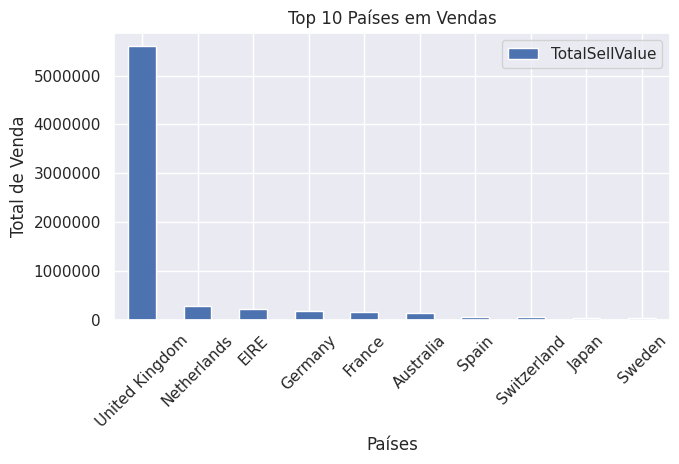

In [ ]:
plotTopPaises = dfTopPaises.plot.bar(x='Country',
                          y='TotalSellValue',
                          title='Top 10 Países em Vendas')

plt.xlabel('Países')
plt.ylabel('Total de Venda')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ticklabel_format(axis='y', style='plain')
plt.show()

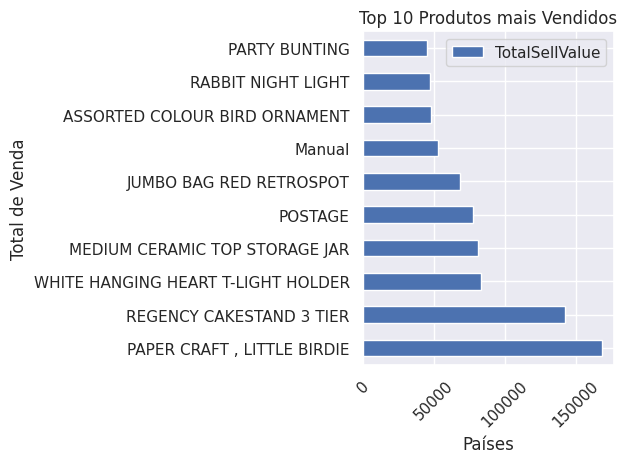

In [ ]:
plotTopProdutos = dfTopProdutos.plot.barh(x='Description',
                          y='TotalSellValue',
                          title='Top 10 Produtos mais Vendidos')

plt.xlabel('Países')
plt.ylabel('Total de Venda')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

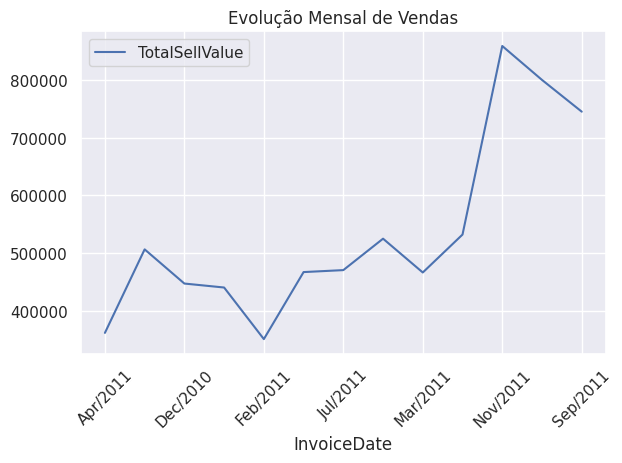

In [ ]:
plotEvolMes = dfVendasMes.plot(x='InvoiceDate',
                          y='TotalSellValue',
                          title='Evolução Mensal de Vendas')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

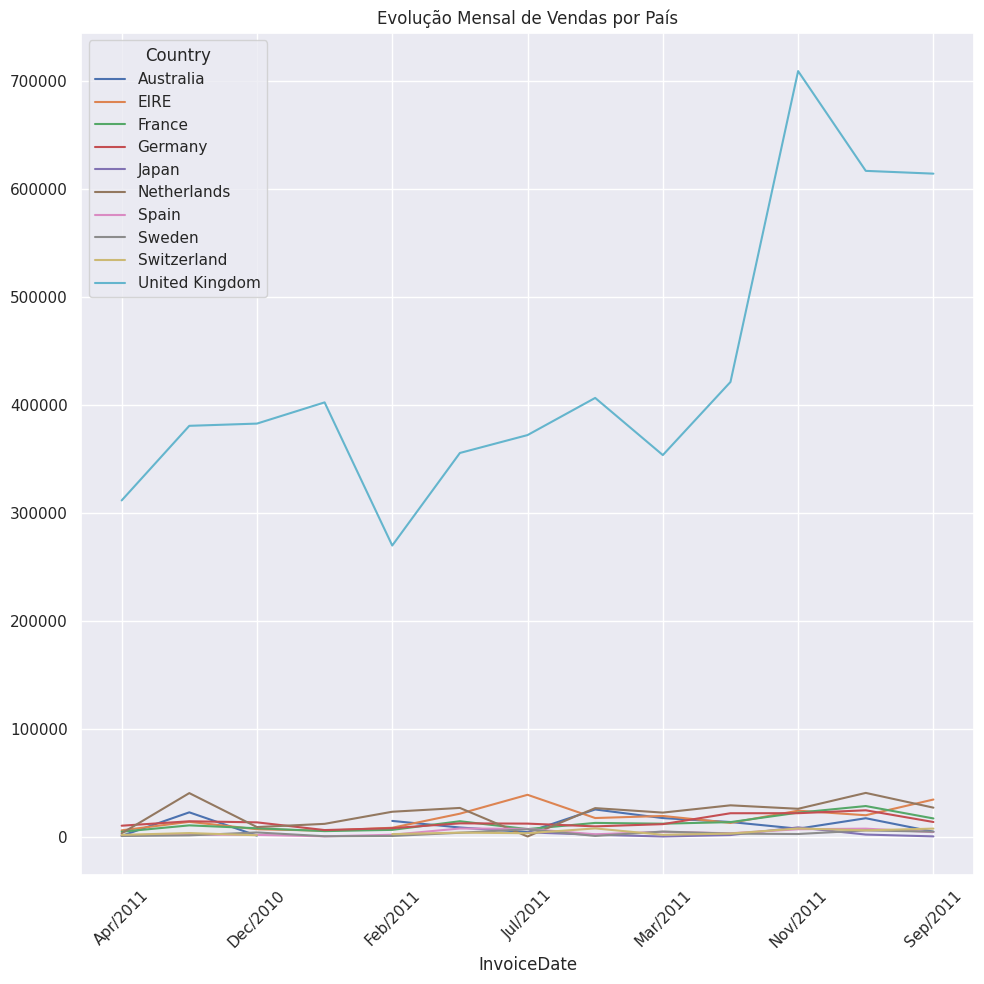

In [ ]:
plotEvolMensalPaises = dfVendasMesPaises.pivot(index='InvoiceDate',
                                               columns='Country',
                                               values='TotalSellValue')

plotEvolMensalPaises.plot(figsize=(10,10),
                          title='Evolução Mensal de Vendas por País')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()